In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import heapq as heap
import networkx as nx

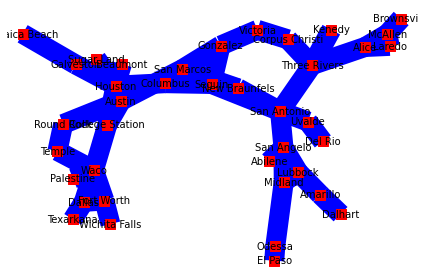

In [ ]:
colnames = ['city', 'longitude', 'latitude']
cities = pd.read_csv('cities.csv', names=colnames, index_col='city')
distances = pd.read_csv('distances.csv', names = ['city1', 'city2', 'distance'])
adjMatrix = pd.DataFrame()
adjMatrix.__init__(data = -1, index = cities.index, columns = cities.index, dtype=float)
for route in distances.iterrows():
    city1 = route[1]['city1']
    city2 = route[1]['city2']
    distance = route[1]['distance']
    adjMatrix[city1][city2] = distance
    adjMatrix[city2][city1] = distance


G = nx.Graph()
d = open("distances.csv", "r")
for _ in d:
  _d = _.split(',')
  G.add_edge(_d[0], _d[1], weight=float(_d[2].replace('-', ' '))/100)

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

pos = nx.spring_layout(G, seed=1)

# nodes
nx.draw_networkx_nodes(G, pos, node_size=100, node_color="r",node_shape='s', margins=100)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=20,edge_color="b",style='solid')
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=20, alpha=1, edge_color="b", style="solid", min_source_margin=.10)

# labels
nx.draw_networkx_labels(G, pos, font_size=10)

#labels = nx.get_edge_attributes(G,'weight')
#nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

ax = plt.gca()
ax.margins(0.00001)
plt.axis("off")
plt.tight_layout()
plt.show()

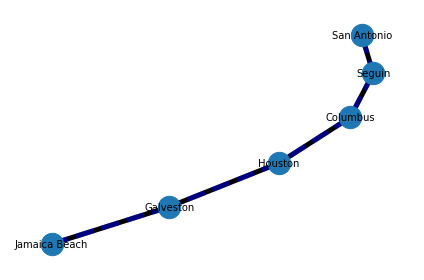

In [ ]:
def findPath(parents, start, goal, path):
    if goal == start:
        return path
    else:
        parent = parents.loc[goal, 'parent']
        path.insert(0, parent)
        goal = parent
        path = findPath(parents, start, goal, path)
        return path


def BFS(graph, start, goal):
    front, explored, unexplored = [], [], list(adjMatrix.index)
    numCities = len(unexplored)
    parents = pd.DataFrame([0]*numCities, index=unexplored, columns=['parent'])
    unexplored.remove(start)
    front.append(start)
    while front:
        current = front.pop(0)
        if goal == current:
            path = [goal]
            path = findPath(parents, start, goal, path)
            return path
        else:
            connected = adjMatrix[current]
            for city, distance in connected.iteritems():
                if distance != -1 and (city not in front and city not in explored):
                    parents.loc[city, 'parent'] = current
                    unexplored.remove(city)
                    front.append(city)
            explored.append(current)
    return False

r = BFS(adjMatrix, 'San Antonio', 'Jamaica Beach')
_G = nx.Graph()
for i in range(len(r)):
  if i < len(r) - 1:
    _G.add_edge(r[i], r[i+1])
pos = nx.spring_layout(_G, seed=i)
nx.draw_networkx_nodes(_G, pos, node_size=i*100)
nx.draw_networkx_edges(_G, pos, width=5)
nx.draw_networkx_edges(_G, pos, width=5, alpha=0.5, edge_color="b", style="dashed")
nx.draw_networkx_labels(_G, pos, font_size=10, font_family="sans-serif")
ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

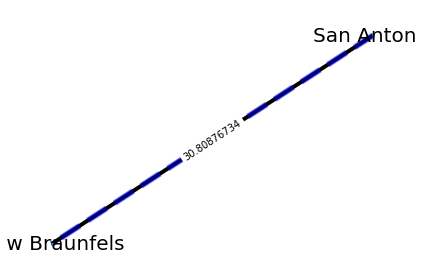

In [ ]:
def updateLog(travel, city, parent, cost, steps):
    travel.loc[city, 'parent'] = parent
    travel.loc[city, 'path cost'] = cost
    travel.loc[city, 'step cost'] = steps
    return travel


def cityInFront(front, target):
    found = False
    for cost, city in front:
        if city == target:
            found = True
    return found

def cityNotInfront(front, target):
    if cityInFront(front, target):
        return False
    else:
        return True


def UniformCostSearch(graph, start, goal):
    front, explored, unexplored, cities = [], [], list(graph.index), list(graph.index)
    numCities = len(cities)
    parents = [0]*numCities
    cost = [-1]*numCities
    steps = [-1]*numCities
    travel = pd.DataFrame(list(zip(parents, cost, steps)), index=cities, columns=['parent', 'path cost', 'step cost'])
    travel = updateLog(travel, start, 'start', 0, 0)
    unexplored.remove(start)
    heap.heappush(front, (0, start))
    while front or unexplored:
        if not front:
            print('path not found')
            return False
        (currentcost, currentCity) = heap.heappop(front)
        explored.append(currentCity)
        connectedCities = graph[:][currentCity]
        for city, steps in connectedCities.items():
            if (steps != -1):
                cost = travel.loc[currentCity, 'path cost'] + steps
                if cityNotInfront(front, city) and (city not in explored):
                    heap.heappush(front, (cost, city))
                    if city in unexplored:
                        unexplored.remove(city)
                    travel = updateLog(travel, city, currentCity, cost, steps)
                elif cityInFront(front, city):
                    index = next((i for i, item in enumerate(front) if item[1] == city), None)
                    (oldcost, city) = front[index]
                    if oldcost > cost:
                        front[index] = front[-1]
                        front.pop()
                        heap.heapify(front)
                        travel = updateLog(travel, city, currentCity, cost, steps)
                elif city in explored:
                    oldcost = travel.loc[city, 'path cost']
                    if oldcost > cost:
                        heap.heappush(front, (cost, city))
                        explored.remove(city)
                        travel = updateLog(travel, city, currentCity, cost, steps)
    path = [goal]
    parents = pd.DataFrame(travel['parent'], index = cities, columns = ['parent'])
    path = findPath(parents, start, goal, path)
    return (path, travel.loc[goal, 'path cost'])


res = UniformCostSearch(adjMatrix, 'San Antonio', 'New Braunfels')
_G = nx.Graph()
_G.add_edge(res[0][0], res[0][1], weight=res[1])
pos = nx.spring_layout(_G, seed=1)
nx.draw_networkx_nodes(_G, pos, node_size=4)
nx.draw_networkx_edges(_G, pos, width=4)
nx.draw_networkx_edges(_G, pos, width=6, alpha=0.5, edge_color="b", style="dashed")
nx.draw_networkx_labels(_G, pos, font_size=20, font_family="sans-serif")
labels = nx.get_edge_attributes(_G,'weight')
nx.draw_networkx_edge_labels(_G,pos,edge_labels=labels)
ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
def UCS(graph, s, goal):
	nodesQ = []
	visited_nodes = {}
	prev_nodes = {}
    
	heappush(nodesQ,(0,s,None,0))
	for nodes in graph:
		visited_nodes[nodes] = False
		prev_nodes[nodes] = None
	i = 1
	while len(nodesQ) != 0:
		i = i+1
		total_cost, current_node, prev_node, link_cost = heappop(nodesQ)
		if visited_nodes[current_node] == False:
			visited_nodes[current_node] = True
			prev_nodes[current_node] = []
			prev_nodes[current_node].append(prev_node)
			prev_nodes[current_node].append(link_cost)
            
			if current_node == goal:
				final = []
				while current_node != s:
					temp = []
					temp.append(current_node)
					for i in prev_nodes[current_node]:
						temp.append(i)
					final.append(temp)
					current_node = prev_nodes[current_node][0]
				final.reverse()
                
				return total_cost,final
            
			for neighbors, ncost in graph[current_node].items():
				if visited_nodes[neighbors] == False:
					this_link_cost = ncost
					new_cost = total_cost + ncost
					heappush(nodesQ, (new_cost, neighbors, current_node, ncost))

	return None

In [ ]:
from sys import argv
from heapq import heappush, heappop
import csv

def main(arg1, arg2):
    Source=arg1
    Destination=arg2

    with open('distances.csv', newline='') as f:
        reader = csv.reader(f)
        data = list(reader)


    G = {}
    for rec in data:
        src = rec[0]
        dest = rec[1]
        cst = rec[2]
        if src not in G:
            G[src] = {}
        if dest not in G:
            G[dest] = {}
            
        G[src][dest] = int(float(cst))
        G[dest][src] = int(float(cst))


    result = UCS(G,Source,Destination)

    print("\n\nFinal output: \n")
    if result == None:
        print("\ndistance: infinity\nroute:\nnone\n")
    else:
        print("\ndistance:",result[0],"km\nroute:")
        for line in result[1]:
            print("%s to %s, %s km" % (line[1],line[0],line[2]))
        print("")

    pass
main('Three Rivers','New Braunfels')



Final output: 


distance: 104 km
route:
Three Rivers to San Antonio, 74 km
San Antonio to New Braunfels, 30 km

